In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/' +'QueryResults.csv')

In [ ]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          27528 non-null  object
 1   Body           27528 non-null  object
 2   Tags           27528 non-null  object
 3   Id             27528 non-null  int64 
 4   Score          27528 non-null  int64 
 5   ViewCount      27528 non-null  int64 
 6   FavoriteCount  27528 non-null  int64 
 7   AnswerCount    27528 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.7+ MB


In [ ]:
df.duplicated().sum()

0

In [ ]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=a83a1a40c9f83b02d353ebf6af4ece9dc6917720842b85fef98d1a82d81c73e3
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from langdetect import detect

for index in df.index:
  df.loc[index,'lang'] = detect(df.loc[index,'Body']) 

df['lang'].value_counts()

en    27461
ca       18
fr       13
nl        9
pt        9
ro        8
da        4
es        3
it        2
cs        1
Name: lang, dtype: int64

Nous filtrons le jeu de données suivant le corps rédigé en anglais:

In [ ]:
df = df[df['lang']=='en']

Ensuite, nous allons supprimer les valises <> des tags: 

In [ ]:
for index in df.index:
   # Replace open and close balise 
   df.loc[index,'Tags']=df.loc[index,'Tags'].replace('<','').replace('>', ',')


# Delete last "," for each row
df['Tags'] = df['Tags'].str[:-1]
df.Tags.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0                 java,android,arrays,list,collections
1     language-agnostic,oop,immutability,setter,getter
2         c,file,directory,cross-platform,common-tasks
3                   c#,.net,wcf,web-services,datatable
4    javascript,angularjs,selenium,selenium-webdriv...
Name: Tags, dtype: object

In [ ]:
df.Body.head(3)

0    <p>I'm porting a Hangman game to Android and h...
1    <p>Allen Holub wrote the following,</p>\n\n<bl...
2    <p>How do you scan a directory for folders and...
Name: Body, dtype: object

In [ ]:
def count_split_text(df, column):  
  list_tags = []
  for word in df['Tags'].str.split(','):
     list_tags.extend(word)

  df_list_tags = pd.DataFrame(list_tags, columns=["Tag"])
  df_list_tags = df_list_tags.groupby("Tag").agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
  df_list_tags.sort_values("tag_count", ascending=False, inplace=True)
  return df_list_tags

In [ ]:
tags_list = count_split_text(df=df, column='Tags')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 12514 tags.


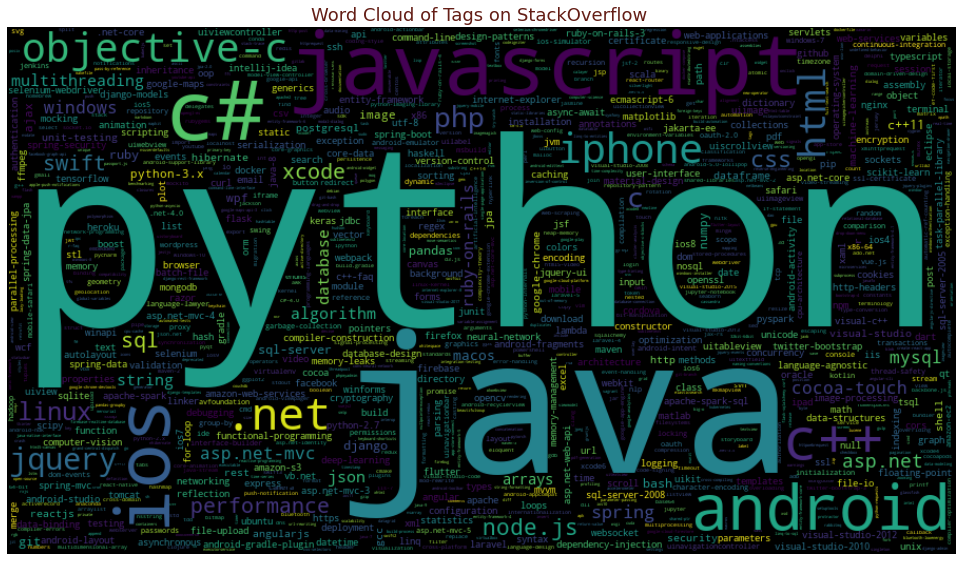

In [ ]:
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=1000, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(tags_list.to_dict()['tag_count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of Tags on StackOverflow ",
          fontsize=18, color="#641E16")
plt.show()

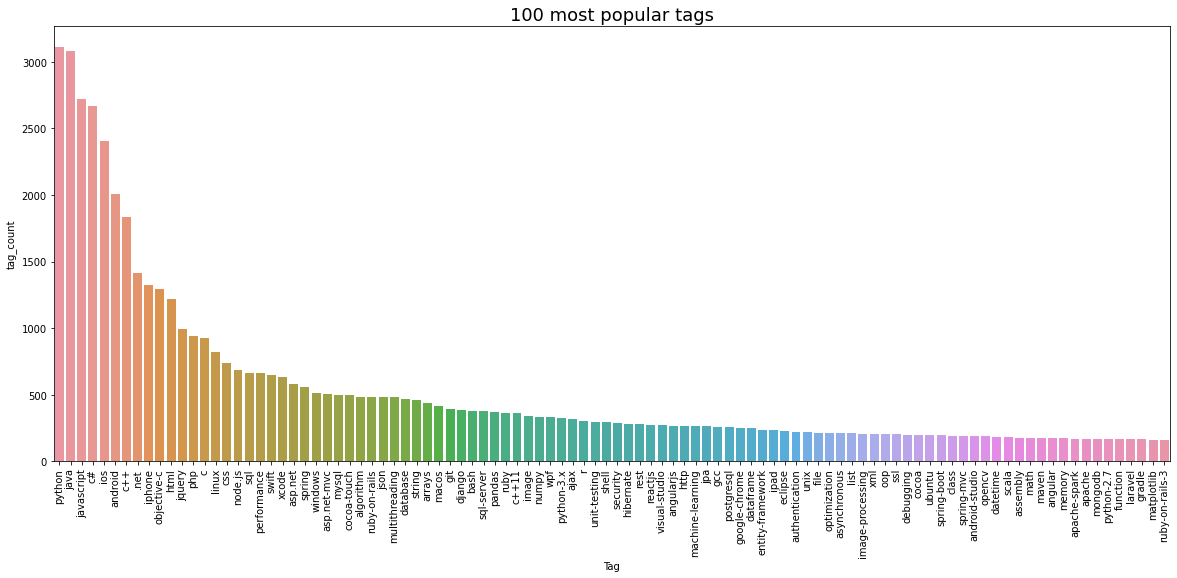

In [ ]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=tags_list.iloc[0:100, :],
            x=tags_list.iloc[0:100, :].index,
            y="tag_count")
plt.xticks(rotation=90)
plt.title("100 most popular tags",
          fontsize=18)
plt.show()

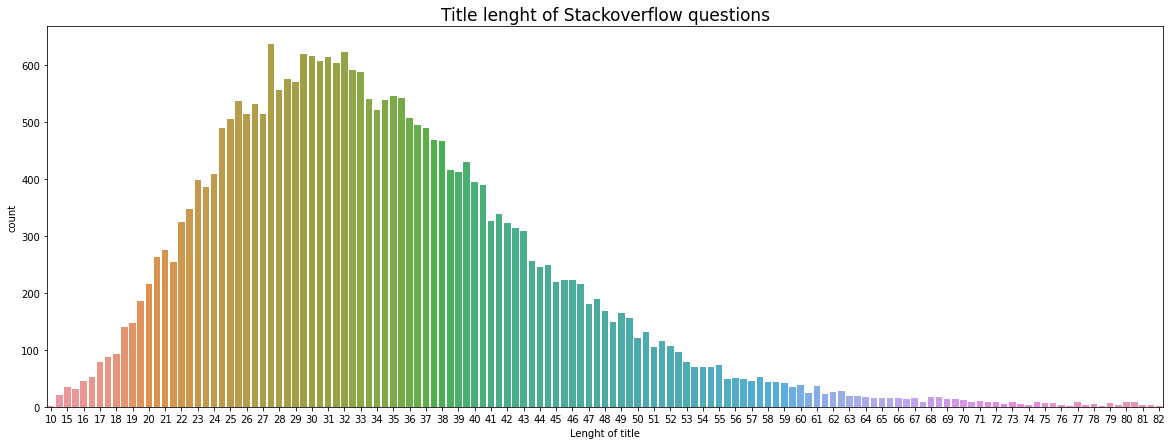

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.countplot(x=df.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end,2))
ax.set_xlabel("Lenght of title")
plt.title("Title lenght of Stackoverflow questions",
          fontsize=17)
plt.show()

In [ ]:
def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace 
    the content of all the <code> </code> tags of a text specified as a parameter.
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [ ]:
df['Body'] = df['Body'].apply(lambda text: remove_code(text))

In [ ]:
df.Body = [BeautifulSoup(text,"lxml").get_text() for text in df.Body]

In [ ]:
def clean_text(text):
    #Make text lowercase
    text = text.lower()
    # Remove English contractions
    text = re.sub("\'\w+", ' ', text)
    #
    text = text.encode("ascii", "ignore").decode()
    # Remove ponctuation (except # and ++ for c# and c++)
    text = re.sub('[^\\w\\s#\\s++]', ' ', text)
    # Remove links
   # text = re.sub(r'http*\S+', ' ', text)
    # Remove numbers
    text = re.sub(r'\w*\d+\w*', ' ', text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    return text

In [ ]:
# Applying the cleaning function 
df['Body'] = df['Body'].apply(lambda text: clean_text(text))
df['Title'] = df['Title'].apply(lambda text: clean_text(text))
df['Tags'] = df['Tags'].apply(lambda text: clean_text(text))

In [ ]:
df[['Body','Title','Tags']].head()

,Body,Title,Tags
0,i porting a hangman game to android and have m...,print array without brackets and commas,java android arrays list collections
1,allen holub wrote the following you can have a...,allen holub wrote you should never use get set...,language agnostic oop immutability setter getter
2,how do you scan a directory for folders and fi...,how do you get a directory listing in c,c file directory cross platform common tasks
3,i have a wcf service from which i want to retu...,returning datatables in wcf net,c# net wcf web services datatable
4,i want to click on a radio button appears on a...,element not visible error not able to click an...,javascript angularjs selenium selenium webdriv...


In [ ]:
def words_tokenize(text):
  text = text.split()
  return text

In [ ]:
df['Body'] = df.Body.apply(lambda text: words_tokenize(text))
df['Title'] = df.Title.apply(lambda text: words_tokenize(text))
df['Tags'] = df.Tags.apply(lambda text: words_tokenize(text))

La lemmatisation ("*lemmatization*") est le processus de conversion d'un mot en sa forme de base en prenant compte contexte. La différence entre la avec la radicalisation ("*stemming*") est que ce dernier supprime les suffixes, implique souvent des significations incorrectes et des fautes d'orthographe. Nous utilisons ici "Wordnet Lemmatizer" avec des POS appropriées basabt sur la fonction "nltk.pos_tag".

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()
def lem_word(text):
  # 3. Lemmatize with the appropriate POS tag
  return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
df['Body'] = df.Body.apply(lem_word)
df['Title'] = df.Title.apply(lem_word)
df['Tags'] = df.Tags.apply(lem_word)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df[['Body','Title','Tags']].head()

,Body,Title,Tags
0,"[i, port, a, hangman, game, to, android, and, ...","[print, array, without, bracket, and, comma]","[java, android, array, list, collection]"
1,"[allen, holub, write, the, follow, you, can, h...","[allen, holub, write, you, should, never, use,...","[language, agnostic, oop, immutability, setter..."
2,"[how, do, you, scan, a, directory, for, folder...","[how, do, you, get, a, directory, listing, in, c]","[c, file, directory, cross, platform, common, ..."
3,"[i, have, a, wcf, service, from, which, i, wan...","[return, datatables, in, wcf, net]","[c#, net, wcf, web, service, datatable]"
4,"[i, want, to, click, on, a, radio, button, app...","[element, not, visible, error, not, able, to, ...","[javascript, angularjs, selenium, selenium, we..."


In [ ]:
stop_words = []
# open file and read the content in a list
with open('/content/drive/MyDrive/' +'stop_words_en.txt', "r") as fp:
    for line in fp:
        # remove linebreak from a current name
        x = line[:-1]
        stop_words.append(x)

In [ ]:
most_tag = tags_list.iloc[0:200, :].index
list_swc = []
for word in most_tag:
  if word in stop_words:
    list_swc.append(word)
    stop_words.remove(word)

print(list_swc)
len(stop_words)

['html', 'c', 'r', 'shell', 'http', 'date']


1292

In [ ]:
# removing stopwords
def remove_stopwords(raw):
    words = [w for w in raw if w not in stop_words ]
    return words 
    
df.Body = df.Body.apply(lambda word : remove_stopwords(word))
df.Title = df.Title.apply(lambda word : remove_stopwords(word))
df.Tags = df.Tags.apply(lambda word : remove_stopwords(word))
df[['Body','Title','Tags']].head()

,Body,Title,Tags
0,"[port, hangman, game, android, met, original, ...","[print, array, bracket, comma]","[java, android, array, list, collection]"
1,"[allen, holub, write, follow, program, couple,...","[allen, holub, write, set, function, correct]","[language, agnostic, oop, immutability, setter..."
2,"[scan, directory, folder, file, c, cross, plat...","[directory, listing, c]","[c, file, directory, cross, platform, common, ..."
3,"[wcf, service, return, datatable, highly, deba...","[return, datatables, wcf]","[c#, wcf, service, datatable]"
4,"[radio, button, code, follow, html, code, tess...","[element, visible, error, element]","[javascript, angularjs, selenium, selenium, we..."


In [ ]:
data = df.copy()

Supprimer les mots récurrents dans la même liste:

In [ ]:
data.Tags = data.Tags.apply(lambda raw : list(set(raw)))
data.Title = data.Title.apply(lambda raw : list(set(raw)))
data.Body = data.Body.apply(lambda raw : list(set(raw)))

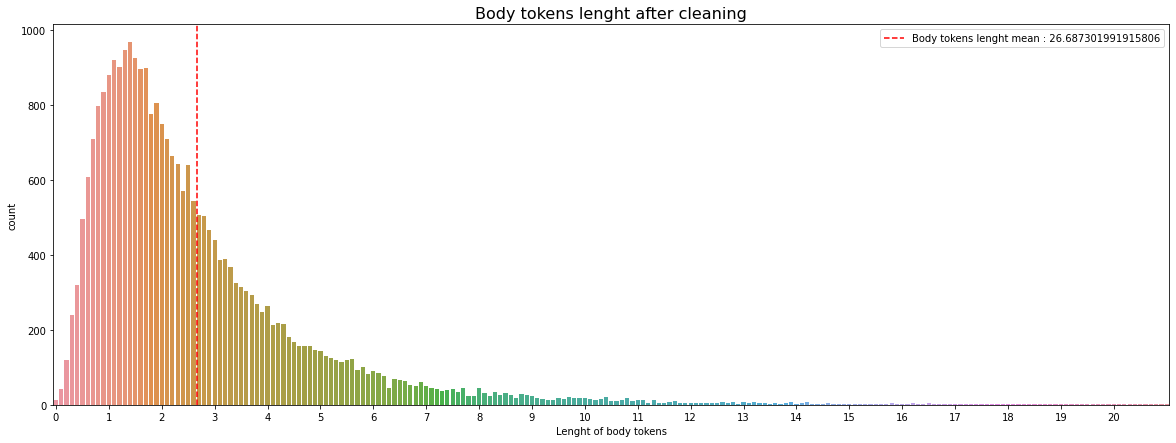

In [ ]:
# Calculate lenght of each list in Body
data['body_count'] = [len(raw) for raw in data.Body]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 7))
ax = sns.countplot(x=data.body_count)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, int(end), 10))
plot_mean = data.body_count.mean()
plt.axvline(plot_mean, color="r", linestyle='--', label="Body tokens lenght mean : "+str(plot_mean))
ax.set_xlabel("Lenght of body tokens")
plt.title("Body tokens lenght after cleaning",
          fontsize=16)
plt.legend()
plt.show()

In [ ]:
data.shape

(27461, 10)

In [ ]:
# Filter data on body lenght
data = data[(5<data['body_count']) & (data['body_count']<150)]
data.shape

(26128, 10)

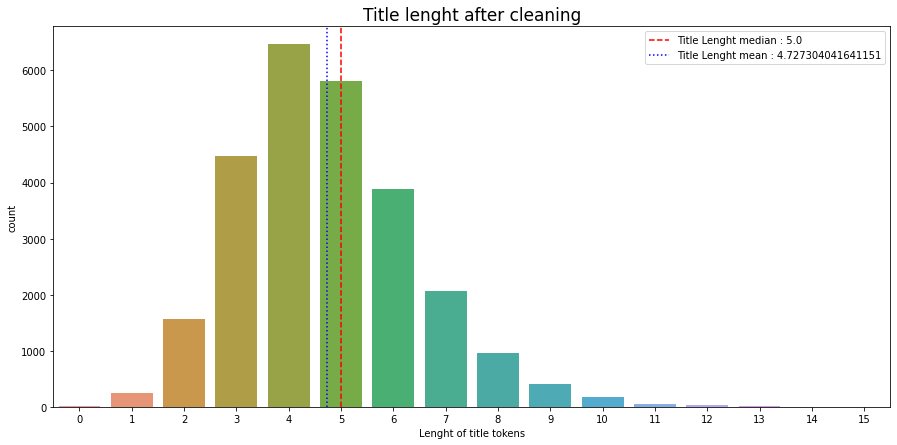

In [ ]:
# Calculate lenght of each list in Body
data['Title_count'] = [len(text) for text in data.Title]

# Countplot of body lenght
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(x=data.Title_count)
median_plot = data.Title_count.median()
plt.axvline(median_plot ,
            color="r", linestyle='--',
            label="Title Lenght median : "+str(median_plot))
mean_plot = data.Title_count.mean()
plt.axvline(mean_plot ,
            color="b", linestyle=':',
            label="Title Lenght mean : "+str(mean_plot))
ax.set_xlabel("Lenght of title tokens")
plt.title("Title lenght after cleaning",
          fontsize=17)
plt.legend()
plt.show()

In [ ]:
# Filter data on body lenght
data = data[(data['Title_count']>2)&(data['Title_count']<12)]
data.shape

(24269, 11)

In [ ]:
Tag_tokens = [token for token_list in data.Tags for token in token_list]
df_word_freq = pd.DataFrame(nltk.FreqDist(Tag_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
df_word_freq.sort_values("frequency", ascending=False, inplace=True)
df_word_freq.head(20)

,frequency
tag,
python,2839
java,2814
javascript,2436
c#,2358
android,1904
c,1822
c++,1603
iphone,1168
html,1108


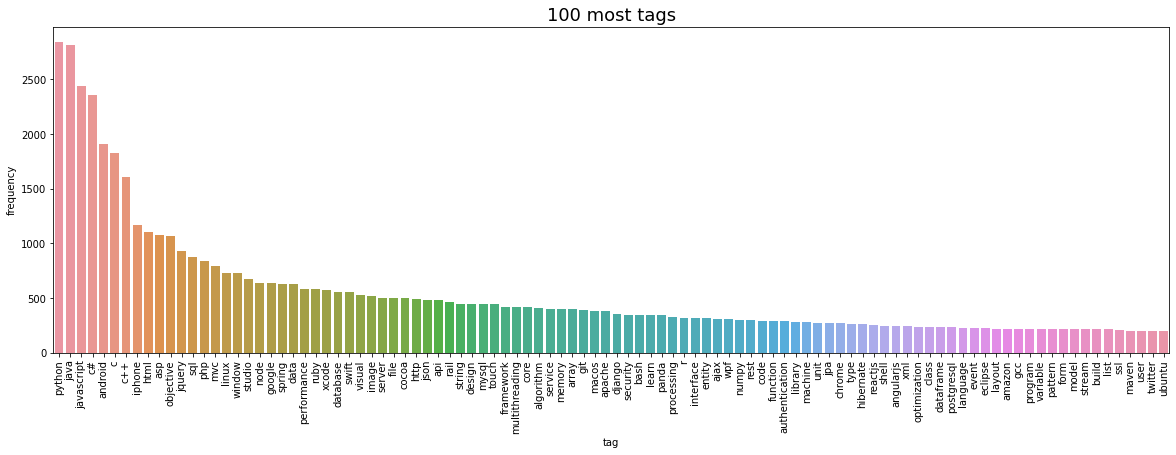

In [ ]:
fig = plt.figure(figsize=(20, 6))
sns.barplot(data=df_word_freq.iloc[0:100, :],
            x=df_word_freq.iloc[0:100, :].index,
            y="frequency")
plt.xticks(rotation=90)
plt.title("100 most tags",
          fontsize=18)
plt.show()

In [ ]:
# filtering data from 50 most tags
def filter_tags(raw):
    tokens = [w for w in raw if w in  df_word_freq[0:50].index ]
    return tokens 

data.Tags = data.Tags.apply(lambda word : filter_tags(word))

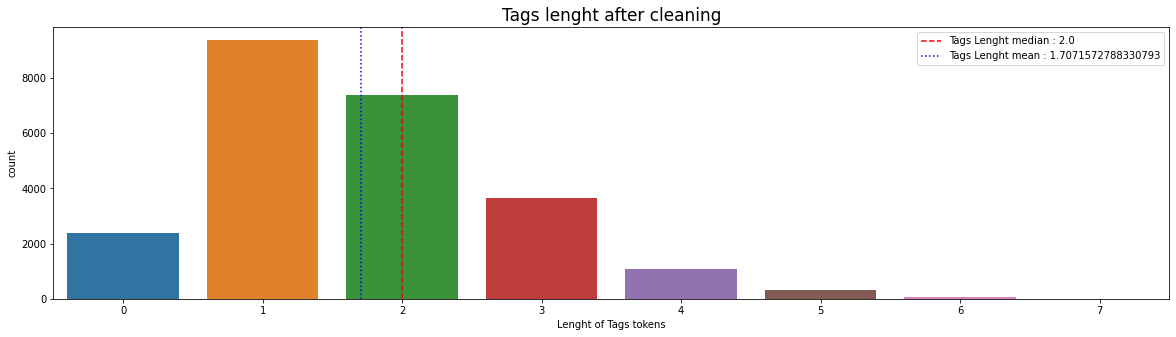

In [ ]:
# Calculate lenght of each list in Body
data['Tags_count'] = [len(text) for text in data.Tags]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x=data.Tags_count)
median_plot = data.Tags_count.median()
plt.axvline(median_plot ,
            color="r", linestyle='--',
            label="Tags Lenght median : "+str(median_plot))
mean_plot = data.Tags_count.mean()
plt.axvline(mean_plot ,
            color="b", linestyle=':',
            label="Tags Lenght mean : "+str(mean_plot))
ax.set_xlabel("Lenght of Tags tokens")
plt.title("Tags lenght after cleaning",
          fontsize=17)
plt.legend()
plt.show()

In [ ]:
# Filter data on body lenght
data = data[data['Tags_count']>0]
data.shape

(21875, 12)

In [ ]:
data.Tags_count.head()

0    3
2    2
3    2
4    1
6    3
Name: Tags_count, dtype: int64

Nous allons réduire le nombre de tags en ne retenant que les 100 premiers tags,
afin d'augementer l'efficacité des modèles supervisés.

In [ ]:
data.Tags.head()

0    [array, android, java]
2                 [c, file]
3             [c#, service]
4              [javascript]
6    [database, php, mysql]
Name: Tags, dtype: object

In [ ]:
data['text_comb'] = data['Body'] + data['Title']

In [ ]:
top_tag = df_word_freq[0:50].index
data['Tags_shar_length'] = data.text_comb.apply(lambda raw : len(top_tag)-len(set(top_tag)-set(raw)))
data = data[data['Tags_shar_length']>0]
data.shape

(19117, 14)

In [ ]:
data.head(3)

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,lang,body_count,Title_count,Tags_count,text_comb,Tags_shar_length
0,"[comma, array, print, bracket]","[fit, console, game, original, format, comma, ...","[array, android, java]",4389480,55,192840,17,12,en,30,4,3,"[fit, console, game, original, format, comma, ...",3
2,"[directory, c, listing]","[scan, c, file, folder, platform, cross, direc...","[c, file]",12489,68,138108,22,9,en,7,3,2,"[scan, c, file, folder, platform, cross, direc...",2
3,"[return, wcf, datatables]","[table, underlie, timeouts, data, connection, ...","[c#, service]",12702,51,56351,12,8,en,38,3,2,"[table, underlie, timeouts, data, connection, ...",4


In [ ]:
# Export to CSV
data[['Title', 'Body','Tags','text_comb']].to_csv("Stack_questions_cleaned.csv", index=False,header=True,sep=';')

In [ ]:
# Define X and y
X = data["text_comb"]
y = data["Tags"]

# Initialize the "CountVectorizer" TFIDF for text_comb
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.98,
                             min_df=5,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X for Full_doc: (22858, 7328)
Shape of y: (22858, 100)


In [ ]:
# Create train and test split (25%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.25, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (17143, 7328)
X_test shape : (5715, 7328)
y_train shape : (17143, 100)
y_test shape : (5715, 100)


In [ ]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.98, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 5), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('android', 2),
  ('array', 5),
  ('bit', 1),
  ('bracket', 2),
  ('class', 1),
  ('code', 1),
  ('comma', 2),
  ('console', 1),
  ('correct', 1),
  ('fit', 1),
  ('format', 1),
  ('function', 1),
  ('game', 1),
  ('guess', 1),
  ('java', 1),
  ('layout', 1),
  ('letter', 1),
  ('met', 1),
  ('original', 1),
  ('output', 2),
  ('port', 1),
  ('print', 4),
  ('program', 1),
  ('replace', 1),
  ('simply', 1),
  ('single', 1),
  ('slash', 1),
  ('usual', 1)]]

## Modèles supervisés

In [ ]:
multi_logit_cv = OneVsRestClassifier(LogisticRegression())
multi_logit_cv.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*100)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 100)
print("Predicted:", y_test_pred_inversed[10:20])
print("True:", y_test_inversed[0:5])

----------------------------------------------------------------------------------------------------
Print 5 first predicted Tags vs true Tags
----------------------------------------------------------------------------------------------------
Predicted: [('c', 'c++', 'gcc'), ('datetime', 'mysql'), ('iphone',), (), ('gradle',), (), (), ('html',), (), ('mvc', 'pdf', 'spring')]
True: [('angularjs', 'javascript'), ('facebook', 'iphone', 'swift'), ('android', 'javascript'), ('c', 'macos', 'objective'), ('asp', 'json', 'linq', 'parameter')]


In [ ]:
scores = []
    
scores.append(metrics.accuracy_score(y_test, y_test_predicted_labels_tfidf))
scores.append(metrics.f1_score(y_test, y_test_predicted_labels_tfidf, average='weighted'))
scores.append(metrics.jaccard_score(y_test, y_test_predicted_labels_tfidf, average='weighted'))
scores.append(metrics.recall_score(y_test, y_test_predicted_labels_tfidf, average='weighted'))
scores.append(metrics.precision_score(y_test, y_test_predicted_labels_tfidf, average='weighted'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
scores

[0.25899490167516387,
 0.45812224434962984,
 0.3174391007162077,
 0.33629655969419503,
 0.813304896092313]

In [ ]:
scores

[0.10632100203903291,
 0.3965111763476905,
 0.27054274208903206,
 0.2856109158569361,
 0.7736263560014677]

In [ ]:
dt.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,lang,text_comb
0,"[print, array, bracket, comma]","[port, hangman, game, android, met, problem, o...","[java, android, array, list, collection]",4389480,55,192840,17,12,en,"[port, hangman, game, android, met, problem, o..."
1,"[allen, holub, write, use, set, function, corr...","[allen, holub, write, follow, program, couple,...","[language, agnostic, oop, immutability, setter...",996179,51,9946,26,13,en,"[allen, holub, write, follow, program, couple,..."
2,"[directory, listing, c]","[scan, directory, folder, file, c, need, cross...","[c, file, directory, cross, platform, common, ...",12489,68,138108,22,9,en,"[scan, directory, folder, file, c, need, cross..."
3,"[return, datatables, wcf, net]","[wcf, service, want, return, datatable, know, ...","[c#, net, wcf, web, service, datatable]",12702,51,56351,12,8,en,"[wcf, service, want, return, datatable, know, ..."
4,"[element, visible, error, able, click, element]","[want, click, radio, button, appear, webpage, ...","[javascript, angularjs, selenium, selenium, we...",37809915,43,44978,21,1,en,"[want, click, radio, button, appear, webpage, ..."


In [ ]:
dt.shape

(27461, 10)

In [ ]:
data.shape

(27461, 10)